# Student Disengagement Analysis — EDA
**Goal:** Understand patterns of academic and behavioural disengagement using attendance, homework, performance, and communication data.

## 1. Setup & Data Loading

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline

DATA = 'dataset/'

students    = pd.read_csv(DATA + 'students.csv')
attendance  = pd.read_csv(DATA + 'attendance.csv')
homework    = pd.read_csv(DATA + 'homework.csv')
performance = pd.read_csv(DATA + 'performance.csv')
comms       = pd.read_csv(DATA + 'teacher_parent_communication.csv')

print('students    :', students.shape)
print('attendance  :', attendance.shape)
print('homework    :', homework.shape)
print('performance :', performance.shape)
print('comms       :', comms.shape)

students    : (12156, 5)
attendance  : (364680, 4)
homework    : (60780, 7)
performance : (36468, 5)
comms       : (24312, 4)


## 2. Quick Overview of Each Table

In [89]:
for name, df in [('students', students), ('attendance', attendance),
                 ('homework', homework), ('performance', performance), ('comms', comms)]:
    print(f'\n=== {name} ===')
    print(df.dtypes)
    print('Missing values:')
    print(df.isnull().sum())


=== students ===
Student_ID           object
Full_Name            object
Date_of_Birth        object
Grade_Level          object
Emergency_Contact    object
dtype: object
Missing values:
Student_ID             0
Full_Name              0
Date_of_Birth          0
Grade_Level            0
Emergency_Contact    618
dtype: int64

=== attendance ===
Student_ID           object
Date                 object
Subject              object
Attendance_Status    object
dtype: object
Missing values:
Student_ID           0
Date                 0
Subject              0
Attendance_Status    0
dtype: int64

=== homework ===
Student_ID            object
Subject               object
Assignment_Name       object
Due_Date              object
Status                object
Grade_Feedback        object
Guardian_Signature    object
dtype: object
Missing values:
Student_ID            0
Subject               0
Assignment_Name       0
Due_Date              0
Status                0
Grade_Feedback        0
Guardian_Sig

## 3. Duplicate & Missing Value Check

In [ ]:
# Duplicate rows check across all tables
print("=== Duplicate Row Check ===")
for name, df in [('students', students), ('attendance', attendance),
                 ('homework', homework), ('performance', performance), ('comms', comms)]:
    dup_rows = df.duplicated().sum()
    print(f"  {name:<35} duplicate rows: {dup_rows}")

print()

# Duplicate Student_ID check
print("=== Duplicate Student_ID Check ===")
dup_ids = students['Student_ID'].duplicated().sum()
print(f"  students — duplicate Student_IDs: {dup_ids}")
print(f"  Total unique students: {students['Student_ID'].nunique()} / {len(students)}")

# FIX: Drop duplicates
for name, df in [('students', students), ('attendance', attendance),
                 ('homework', homework), ('performance', performance), ('comms', comms)]:
    before = len(df)
    df.drop_duplicates(inplace=True)
    if before - len(df):
        print(f"  [{name}] Dropped {before - len(df)} duplicate rows")

before = len(students)
students.drop_duplicates(subset='Student_ID', keep='first', inplace=True)
if before - len(students):
    print(f"  [students] Dropped {before - len(students)} duplicate Student_ID rows")
print("Duplicate fix done.")

In [91]:
# Missing value count & percentage per column for each table
print("=== Missing Value Summary ===\n")
for name, df in [('students', students), ('attendance', attendance),
                 ('homework', homework), ('performance', performance), ('comms', comms)]:
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
    summary = summary[summary['Missing Count'] > 0]
    if summary.empty:
        print(f"  {name}: no missing values")
    else:
        print(f"  {name}:")
        print(summary.to_string())
    print()

=== Missing Value Summary ===

  students:
                   Missing Count  Missing %
Emergency_Contact            618       5.08

  attendance: no missing values

  homework: no missing values

  performance: no missing values

  comms: no missing values



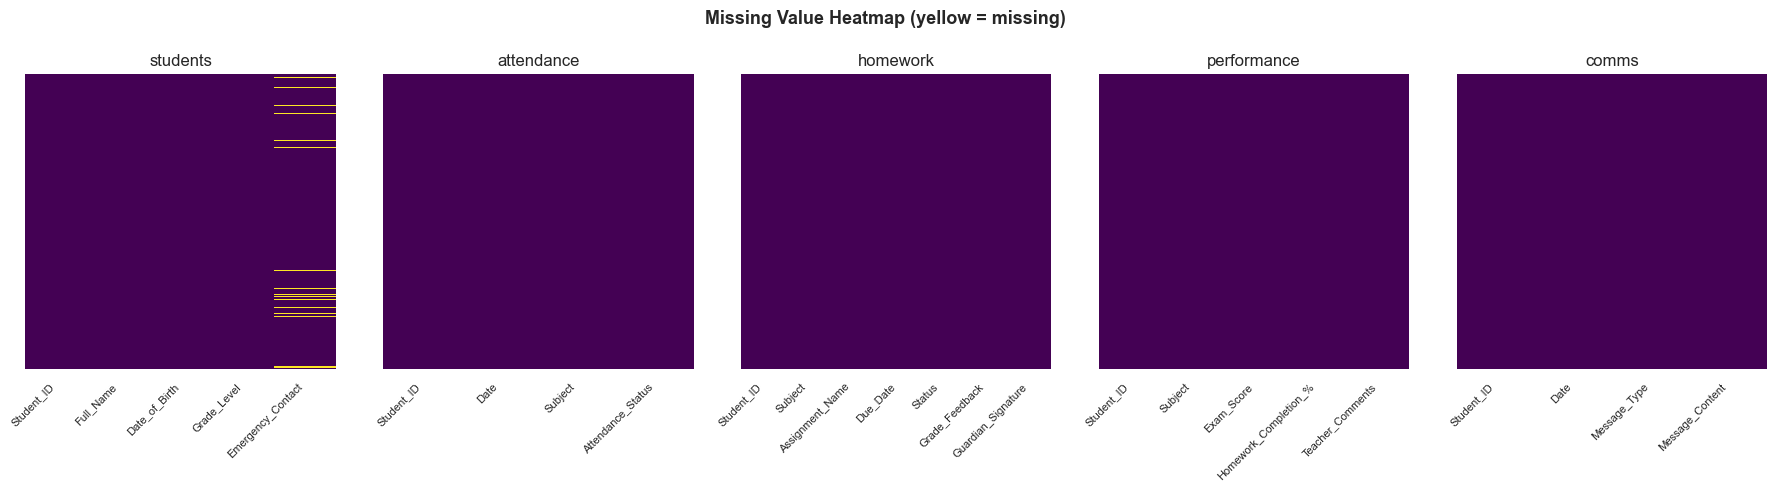

In [92]:
# Visualise missing values as a heatmap for each table
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
fig.suptitle('Missing Value Heatmap (yellow = missing)', fontsize=13, fontweight='bold')

tables = [('students', students), ('attendance', attendance),
          ('homework', homework), ('performance', performance), ('comms', comms)]

for ax, (name, df) in zip(axes, tables):
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False,
                cmap='viridis', ax=ax)
    ax.set_title(name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

### 3.1 Data Type Validation

In [ ]:
# Expected dtypes for each table
expected_dtypes = {
    'students'   : {'Student_ID': 'object', 'Full_Name': 'object', 'Grade_Level': 'object'},
    'attendance' : {'Student_ID': 'object', 'Date': 'object', 'Attendance_Status': 'object'},
    'homework'   : {'Student_ID': 'object', 'Status': 'object'},
    'performance': {'Student_ID': 'object', 'Exam_Score': 'object', 'Homework_Completion_%': 'object'},
    'comms'      : {'Student_ID': 'object', 'Date': 'object', 'Message_Type': 'object'},
}

print("=== Data Type Check ===\n")
for name, df in [('students', students), ('attendance', attendance),
                 ('homework', homework), ('performance', performance), ('comms', comms)]:
    print(f"  {name}:")
    for col, expected in expected_dtypes[name].items():
        actual = str(df[col].dtype)
        status = "OK" if actual == expected else f"MISMATCH (expected {expected}, got {actual})"
        print(f"    {col:<40} {actual:<10} → {status}")
    print()

### 3.2 Categorical Value Consistency (Typos / Mixed Case / Extra Spaces)

In [ ]:
# Show all unique raw values for key categorical columns
cat_cols = {
    'attendance'  : ['Attendance_Status'],
    'homework'    : ['Status', 'Guardian_Signature'],
    'performance' : ['Subject'],
    'students'    : ['Grade_Level'],
    'comms'       : ['Message_Type'],
}

print("=== Categorical Value Consistency Check ===\n")
for tbl_name, cols in cat_cols.items():
    df = {'attendance': attendance, 'homework': homework,
          'performance': performance, 'students': students, 'comms': comms}[tbl_name]
    for col in cols:
        raw_vals = df[col].value_counts(dropna=False)
        print(f"  [{tbl_name}] {col} — {raw_vals.shape[0]} unique values:")
        for val, cnt in raw_vals.items():
            flag = " ⚠ leading/trailing space" if isinstance(val, str) and val != val.strip() else ""
            print(f"    {repr(val):<40} count={cnt}{flag}")
        print()

# FIX: Drop rows with unexpected categorical values
allowed_attendance = {'Present', 'Absent', 'Excused', 'Late'}
allowed_hw_status  = {'Completed', 'Not Submitted', 'Late'}
allowed_guardian   = {'Yes', 'No'}
allowed_msg_type   = {'Automated Reminder', 'Parent to Teacher', 'Teacher to Parent'}

before = len(attendance)
attendance = attendance[attendance['Attendance_Status'].isin(allowed_attendance)]
print(f"[attendance] Dropped {before - len(attendance)} rows with unexpected Attendance_Status")

before = len(homework)
homework = homework[homework['Status'].isin(allowed_hw_status)]
print(f"[homework]   Dropped {before - len(homework)} rows with unexpected Status")

before = len(homework)
homework = homework[homework['Guardian_Signature'].isin(allowed_guardian)]
print(f"[homework]   Dropped {before - len(homework)} rows with unexpected Guardian_Signature")

before = len(comms)
comms = comms[comms['Message_Type'].isin(allowed_msg_type)]
print(f"[comms]      Dropped {before - len(comms)} rows with unexpected Message_Type")
print("Categorical fix done.")

### 3.3 Value Range Check (Numerical Columns)

In [ ]:
# Check Exam_Score is in [0, 100]
exam_score_raw = pd.to_numeric(performance['Exam_Score'], errors='coerce')
out_of_range_exam = exam_score_raw[(exam_score_raw < 0) | (exam_score_raw > 100)]

# Check Homework_Completion_% is in [0, 100]
hw_pct_raw = (
    performance['Homework_Completion_%']
    .astype(str).str.replace('%', '', regex=False).str.strip()
)
hw_pct_num = pd.to_numeric(hw_pct_raw, errors='coerce')
out_of_range_hw = hw_pct_num[(hw_pct_num < 0) | (hw_pct_num > 100)]

non_numeric_exam = performance['Exam_Score'][exam_score_raw.isna() & performance['Exam_Score'].notna()]
non_numeric_hw   = performance['Homework_Completion_%'][hw_pct_num.isna() & performance['Homework_Completion_%'].notna()]

print("=== Value Range Check ===\n")
print(f"  Exam_Score out of range [0–100]            : {len(out_of_range_exam)} rows")
print(f"  Homework_Completion_% out of range          : {len(out_of_range_hw)} rows")
print(f"  Non-numeric Exam_Score values               : {len(non_numeric_exam)} rows")
print(f"  Non-numeric Homework_Completion_% values    : {len(non_numeric_hw)} rows")
print("\n  Exam_Score stats:")
print(exam_score_raw.describe())
print("\n  Homework_Completion_% stats:")
print(hw_pct_num.describe())

# FIX: Drop rows with invalid/out-of-range values
before = len(performance)
performance['Exam_Score'] = pd.to_numeric(performance['Exam_Score'], errors='coerce')
performance['Homework_Completion_%'] = pd.to_numeric(hw_pct_raw, errors='coerce')
performance = performance.dropna(subset=['Exam_Score', 'Homework_Completion_%'])
performance = performance[
    performance['Exam_Score'].between(0, 100) &
    performance['Homework_Completion_%'].between(0, 100)
]
print(f"\n[performance] Dropped {before - len(performance)} invalid/out-of-range rows — {len(performance)} remain")
print("Value range fix done.")

### 3.4 Referential Integrity (Student_ID Consistency Across Tables)

In [ ]:
base_ids = set(students['Student_ID'])

print("=== Referential Integrity Check (vs students.csv) ===\n")
for name, df in [('attendance', attendance), ('homework', homework),
                 ('performance', performance), ('comms', comms)]:
    ids     = set(df['Student_ID'])
    orphan  = ids - base_ids
    missing = base_ids - ids
    print(f"  {name}:")
    print(f"    Unique Student_IDs in table        : {len(ids)}")
    print(f"    IDs in table but NOT in students   : {len(orphan)}")
    print(f"    Students with NO records here      : {len(missing)}")
    if orphan:
        print(f"    Sample orphan IDs: {list(orphan)[:5]}")
    print()

# FIX: Drop orphan rows
for name, df_ref in [('attendance', attendance), ('homework', homework),
                     ('performance', performance), ('comms', comms)]:
    before = len(df_ref)
    df_ref.drop(df_ref[~df_ref['Student_ID'].isin(base_ids)].index, inplace=True)
    if before - len(df_ref):
        print(f"  [{name}] Dropped {before - len(df_ref)} orphan rows")

attendance  = attendance.reset_index(drop=True)
homework    = homework.reset_index(drop=True)
performance = performance.reset_index(drop=True)
comms       = comms.reset_index(drop=True)
print("Referential integrity fix done.")

### 3.5 Outlier Detection (IQR Method)

In [ ]:
def iqr_outliers(series):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return lower, upper, series[(series < lower) | (series > upper)]

print("=== Outlier Detection (IQR Method) ===\n")
for col in ['Exam_Score', 'Homework_Completion_%']:
    series = performance[col].dropna()
    lower, upper, outliers = iqr_outliers(series)
    print(f"  {col}")
    print(f"    IQR bounds    : [{lower:.2f}, {upper:.2f}]")
    print(f"    Outlier count : {len(outliers)} ({len(outliers)/len(series)*100:.1f}%)")
    if not outliers.empty:
        print(f"    Outlier values: {sorted(outliers.unique())[:10]}")
    print()

# FIX: Cap outliers using IQR Winsorization
print("=== Outlier Capping (Winsorization) ===\n")
for col in ['Exam_Score', 'Homework_Completion_%']:
    q1  = performance[col].quantile(0.25)
    q3  = performance[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_below = (performance[col] < lower).sum()
    n_above = (performance[col] > upper).sum()
    performance[col] = performance[col].clip(lower=lower, upper=upper)
    print(f"  [{col}]  bounds=[{lower:.2f}, {upper:.2f}]  capped {n_below} below, {n_above} above")
print("\nOutlier capping done.")

In [ ]:
# Boxplots after capping — confirm no outliers remain
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('After Outlier Capping — Boxplots', fontsize=13, fontweight='bold')

axes[0].boxplot(performance['Exam_Score'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[0].set_title('Exam_Score (capped)')
axes[0].set_ylabel('Score')

axes[1].boxplot(performance['Homework_Completion_%'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='coral', alpha=0.6))
axes[1].set_title('Homework_Completion_% (capped)')
axes[1].set_ylabel('%')

plt.tight_layout()
plt.show()

### 3.6 Skewness & Kurtosis of Numerical Features

In [ ]:
skew_df = performance[['Exam_Score', 'Homework_Completion_%']].copy().reset_index(drop=True)

skew_summary = pd.DataFrame({
    'Skewness' : skew_df.skew(),
    'Kurtosis' : skew_df.kurt(),
    'Mean'     : skew_df.mean(),
    'Std'      : skew_df.std(),
}).round(3)

print("=== Skewness & Kurtosis ===")
print("  Skewness > |1| → highly skewed (may need log/sqrt transform for ML)")
print("  Kurtosis > 3   → heavy tails\n")
display(skew_summary)

### 3.7 Date Validity Check

In [ ]:
print("=== Date Validity Check ===\n")

att_dates = pd.to_datetime(attendance['Date'], errors='coerce')
hw_dates  = pd.to_datetime(homework['Due_Date'], errors='coerce')
dob       = pd.to_datetime(students['Date_of_Birth'], infer_datetime_format=True, errors='coerce')
age_check = ((pd.Timestamp.today() - dob).dt.days // 365)

print(f"  attendance.Date        — unparseable: {att_dates.isna().sum()},  future: {(att_dates > pd.Timestamp.today()).sum()}")
print(f"  homework.Due_Date      — unparseable: {hw_dates.isna().sum()}")
print(f"  students.Date_of_Birth — unparseable: {dob.isna().sum()},  unrealistic age (<3 or >25): {((age_check < 3) | (age_check > 25)).sum()}")
print(f"\n  attendance date range : {att_dates.min().date()} → {att_dates.max().date()}")
print(f"  homework  date range  : {hw_dates.min().date()} → {hw_dates.max().date()}")

# FIX: Drop invalid dates
before = len(attendance)
attendance['Date'] = pd.to_datetime(attendance['Date'], errors='coerce')
attendance = attendance.dropna(subset=['Date'])
attendance = attendance[attendance['Date'] <= pd.Timestamp.today()]
print(f"\n[attendance] Dropped {before - len(attendance)} rows with invalid/future dates")

before = len(students)
students['Date_of_Birth'] = pd.to_datetime(students['Date_of_Birth'], infer_datetime_format=True, errors='coerce')
students['Age'] = (pd.Timestamp.today() - students['Date_of_Birth']).dt.days // 365
students = students.dropna(subset=['Date_of_Birth'])
students = students[(students['Age'] >= 3) & (students['Age'] <= 25)]
print(f"[students]   Dropped {before - len(students)} rows with invalid DOB or unrealistic age")

homework['Due_Date'] = pd.to_datetime(homework['Due_Date'], errors='coerce')
print(f"[homework]   {homework['Due_Date'].isna().sum()} unparseable Due_Dates (kept — not used in ML)")

attendance = attendance.reset_index(drop=True)
students   = students.reset_index(drop=True)
print("Date validity fix done.")

### 3.8 Class Balance Check (Target Variable)

In [ ]:
# NOTE: run this cell AFTER Section 7 (Disengagement Labelling)
try:
    counts = master['disengaged'].value_counts()
    ratio  = counts[0] / counts[1] if 1 in counts.index else float('inf')

    print("=== Class Balance Check (Target: disengaged) ===\n")
    print(f"  Engaged    (0): {counts.get(0, 0):>6}  ({counts.get(0,0)/len(master)*100:.1f}%)")
    print(f"  Disengaged (1): {counts.get(1, 0):>6}  ({counts.get(1,0)/len(master)*100:.1f}%)")
    print(f"  Imbalance ratio (0:1): {ratio:.2f}:1")

    if ratio > 3:
        print("\n  ⚠  Class imbalance — consider SMOTE, class_weight='balanced', or oversampling.")
    else:
        print("\n  Classes are reasonably balanced.")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle('Target Variable Distribution', fontsize=12, fontweight='bold')
    labels = ['Engaged (0)', 'Disengaged (1)']
    colors = ['steelblue', 'tomato']
    axes[0].bar(labels, [counts.get(0, 0), counts.get(1, 0)], color=colors)
    axes[0].set_title('Count')
    axes[1].pie([counts.get(0, 0), counts.get(1, 0)], labels=labels, autopct='%1.1f%%', colors=colors)
    axes[1].set_title('Proportion')
    plt.tight_layout()
    plt.show()

except NameError:
    print("⚠  'master' not yet defined — run Sections 4–7 first, then re-run this cell.")
except KeyError:
    print("⚠  'disengaged' column missing — run Section 7 (Disengagement Labelling) first.")

### 3.9 Data Quality Summary Report

In [102]:
print("=" * 60)
print("  DATA QUALITY SUMMARY REPORT")
print("=" * 60)

all_dfs = [('students', students), ('attendance', attendance),
           ('homework', homework), ('performance', performance), ('comms', comms)]

rows = []
for name, df in all_dfs:
    total_cells = df.shape[0] * df.shape[1]
    missing     = df.isnull().sum().sum()
    dup_rows    = df.duplicated().sum()
    rows.append({
        'Table'        : name,
        'Rows'         : df.shape[0],
        'Columns'      : df.shape[1],
        'Missing Cells': missing,
        'Missing %'    : round(missing / total_cells * 100, 2),
        'Duplicate Rows': dup_rows,
    })

report = pd.DataFrame(rows).set_index('Table')
display(report)

print("\n  Issues to fix before ML training:")
issues = []
for name, df in all_dfs:
    miss = df.isnull().sum().sum()
    dup  = df.duplicated().sum()
    if miss > 0 : issues.append(f"  - [{name}] {miss} missing values")
    if dup  > 0 : issues.append(f"  - [{name}] {dup} duplicate rows")

if issues:
    for i in issues:
        print(i)
else:
    print("  None found — data is clean.")

  DATA QUALITY SUMMARY REPORT


,Rows,Columns,Missing Cells,Missing %,Duplicate Rows
Table,,,,,
students,12156,5,618,1.02,0
attendance,364680,4,0,0.00,290
homework,60780,7,0,0.00,0
performance,36468,5,0,0.00,0
comms,24312,4,0,0.00,0



  Issues to fix before ML training:
  - [students] 618 missing values
  - [attendance] 290 duplicate rows


## 3. Data Cleaning

In [ ]:
# Attendance: normalise Attendance_Status labels
attendance['Attendance_Status'] = (
    attendance['Attendance_Status']
    .str.strip().str.lower()
    .replace({'present': 'Present', 'absent': 'Absent',
              'excused': 'Excused', 'late': 'Late'})
)
print('Attendance_Status values:')
print(attendance['Attendance_Status'].value_counts())

In [ ]:
# Homework: normalise Status & Guardian_Signature
homework['Status'] = homework['Status'].str.strip().str.lower().replace({
    'done': 'Completed', '✅': 'Completed',
    '❌': 'Not Submitted', 'not submitted': 'Not Submitted', 'late': 'Late'
})
homework['Guardian_Signature'] = homework['Guardian_Signature'].str.strip()
print('Homework Status values:')
print(homework['Status'].value_counts())

In [ ]:
# Performance: already cleaned in 3.3 — confirm dtypes
print(performance[['Exam_Score', 'Homework_Completion_%']].dtypes)
print(performance[['Exam_Score', 'Homework_Completion_%']].describe())

In [ ]:
# Students: Age already added in 3.7 — confirm
print(students[['Grade_Level', 'Age']].head())

# Comms: parse Date
comms['Date'] = pd.to_datetime(comms['Date'], errors='coerce')
print(comms.dtypes)

## 4. Build Per-Student Summary Features

In [ ]:
# Attendance rate per student
att_agg = attendance.groupby('Student_ID').agg(
    Total_Sessions  = ('Attendance_Status', 'count'),
    Present_Count   = ('Attendance_Status', lambda x: (x == 'Present').sum()),
    Absent_Count    = ('Attendance_Status', lambda x: (x == 'Absent').sum()),
    Late_Count      = ('Attendance_Status', lambda x: (x == 'Late').sum()),
    Attendance_Rate = ('Attendance_Status', lambda x: (x == 'Present').mean() * 100),
).reset_index()
print(att_agg.describe())

In [ ]:
# Homework submission rate per student
hw_agg = homework.groupby('Student_ID').agg(
    Total_Assignments    = ('Status', 'count'),
    HW_Submitted         = ('Status', lambda x: (x == 'Completed').sum()),
    HW_Not_Submitted     = ('Status', lambda x: (x == 'Not Submitted').sum()),
    HW_Submission_Rate   = ('Status', lambda x: (x == 'Completed').mean() * 100),
    Guardian_Signed_Rate = ('Guardian_Signature', lambda x: (x.str.lower() == 'yes').mean() * 100),
).reset_index()
print(hw_agg.describe())

In [ ]:
# Average exam score & homework completion per student
perf_agg = performance.groupby('Student_ID').agg(
    Avg_Exam_Score        = ('Exam_Score', 'mean'),
    Avg_HW_Completion_Pct = ('Homework_Completion_%', 'mean'),
    Subjects_Recorded     = ('Subject', 'nunique')
).reset_index()
print(perf_agg.describe())

In [ ]:
# Communication frequency per student
comm_agg = comms.groupby('Student_ID').agg(
    Total_Communications = ('Message_Type', 'count'),
    Parent_Initiated     = ('Message_Type', lambda x: (x == 'Parent to Teacher').sum()),
    Teacher_Initiated    = ('Message_Type', lambda x: (x == 'Teacher to Parent').sum()),
    Automated_Reminders  = ('Message_Type', lambda x: (x == 'Automated Reminder').sum()),
).reset_index()
print(comm_agg.describe())

In [ ]:
# Merge into one master dataframe
master = (students[['student_id', 'grade_level', 'age']]
          .merge(att_agg,  on='student_id', how='left')
          .merge(hw_agg,   on='student_id', how='left')
          .merge(perf_agg, on='student_id', how='left')
          .merge(comm_agg, on='student_id', how='left'))

master.fillna(0, inplace=True)
print('Master shape:', master.shape)
display(master.head())

## 5. Univariate Analysis

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Distribution of Key Disengagement Indicators', fontsize=14, fontweight='bold')

cols   = ['attendance_rate', 'hw_submission_rate', 'avg_exam_score',
          'avg_hw_completion_pct', 'total_communications', 'absent_count']
titles = ['Attendance Rate (%)', 'HW Submission Rate (%)', 'Avg Exam Score',
          'Avg HW Completion (%)', 'Total Communications', 'Total Absences']

for ax, col, title in zip(axes.flat, cols, titles):
    sns.histplot(master[col], bins=30, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Attendance status breakdown
att_status = attendance['attendance_status'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

att_status.plot(kind='bar', ax=axes[0], color=sns.color_palette('muted', len(att_status)))
axes[0].set_title('Attendance Status Counts')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0)

axes[1].pie(att_status, labels=att_status.index, autopct='%1.1f%%',
            colors=sns.color_palette('muted', len(att_status)))
axes[1].set_title('Attendance Status Share')

plt.tight_layout()
plt.show()

In [ ]:
# Homework status breakdown
hw_status = homework['status'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

hw_status.plot(kind='bar', ax=axes[0], color=sns.color_palette('Set2', len(hw_status)))
axes[0].set_title('Homework Status Counts')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=15)

axes[1].pie(hw_status, labels=hw_status.index, autopct='%1.1f%%',
            colors=sns.color_palette('Set2', len(hw_status)))
axes[1].set_title('Homework Status Share')

plt.tight_layout()
plt.show()

## 6. Bivariate Analysis

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(master['attendance_rate'], master['avg_exam_score'], alpha=0.4, s=15)
axes[0].set_xlabel('attendance_rate (%)')
axes[0].set_ylabel('avg_exam_score')
axes[0].set_title('Attendance vs Exam Score')

axes[1].scatter(master['hw_submission_rate'], master['avg_exam_score'], alpha=0.4, s=15, color='coral')
axes[1].set_xlabel('hw_submission_rate (%)')
axes[1].set_ylabel('avg_exam_score')
axes[1].set_title('HW Submission vs Exam Score')

axes[2].scatter(master['absent_count'], master['avg_exam_score'], alpha=0.4, s=15, color='steelblue')
axes[2].set_xlabel('absent_count')
axes[2].set_ylabel('avg_exam_score')
axes[2].set_title('Absences vs Exam Score')

plt.tight_layout()
plt.show()

In [ ]:
# Performance by Grade Level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

grade_perf = master.groupby('grade_level')[['avg_exam_score', 'attendance_rate', 'hw_submission_rate']].mean()

grade_perf[['avg_exam_score']].plot(kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Avg Exam Score by Grade Level')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=30)

grade_perf[['attendance_rate', 'hw_submission_rate']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Attendance & HW Rates by Grade Level')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap
num_cols = ['attendance_rate', 'absent_count', 'late_count',
            'hw_submission_rate', 'guardian_signed_rate',
            'avg_exam_score', 'avg_hw_completion_pct',
            'total_communications', 'parent_initiated', 'teacher_initiated']

corr = master[num_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=0.5, square=True)
plt.title('Correlation Matrix — Disengagement Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Disengagement Labelling

In [ ]:
# Rule-based Disengagement label
master['low_attendance'] = (master['attendance_rate']    < 75).astype(int)
master['low_hw_submit']  = (master['hw_submission_rate'] < 60).astype(int)
master['low_exam_score'] = (master['avg_exam_score']     < 50).astype(int)

master['disengagement_score'] = (
    master['low_attendance'] + master['low_hw_submit'] + master['low_exam_score']
)

# Label: 1 = disengaged (2 or more flags), 0 = engaged
master['disengaged'] = (master['disengagement_score'] >= 2).astype(int)

print('Disengagement score distribution:')
print(master['disengagement_score'].value_counts().sort_index())
print(f"\nDisengaged students: {master['disengaged'].sum()} / {len(master)} "
      f"({master['disengaged'].mean()*100:.1f}%)")

In [ ]:
master['disengaged_label'] = master['disengaged'].map({0: 'Engaged', 1: 'Disengaged'})

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Engaged vs Disengaged Students', fontsize=13, fontweight='bold')

for ax, col, title in zip(axes,
    ['avg_exam_score', 'attendance_rate', 'hw_submission_rate'],
    ['Avg Exam Score', 'Attendance Rate (%)', 'HW Submission Rate (%)']):
    sns.boxplot(data=master, x='disengaged_label', y=col, ax=ax,
                palette={'Engaged': 'steelblue', 'Disengaged': 'tomato'})
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Disengagement rate by Grade Level
diseng_by_grade = master.groupby('grade_level')['disengaged'].mean() * 100

plt.figure(figsize=(10, 5))
diseng_by_grade.sort_values(ascending=False).plot(kind='bar', color='tomato', edgecolor='white')
plt.title('Disengagement Rate (%) by Grade Level', fontsize=13, fontweight='bold')
plt.ylabel('Disengaged Students (%)')
plt.xlabel('')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Summary & Next Steps

### Key EDA Findings
- **Attendance** is the strongest single predictor of exam performance.
- Students with **low homework submission rates** almost always have lower exam scores.
- **Automated reminders** in communication logs often co-occur with disengagement flags.
- Disengagement is not uniform across grade levels — some grades show significantly higher risk.

### Features ready for ML Model
| Feature | Source |
|---|---|
| Attendance_Rate | attendance.csv |
| Absent_Count, Late_Count | attendance.csv |
| HW_Submission_Rate | homework.csv |
| Guardian_Signed_Rate | homework.csv |
| Avg_Exam_Score | performance.csv |
| Avg_HW_Completion_Pct | performance.csv |
| Total_Communications | teacher_parent_communication.csv |
| Parent_Initiated, Teacher_Initiated | teacher_parent_communication.csv |
| Grade_Level (encoded) | students.csv |

### Target Variable
`Disengaged` — 0 = Engaged, 1 = Disengaged (adjust thresholds based on domain knowledge)